In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import itertools
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora
from nltk import FreqDist
import seaborn as sns

In [2]:
df = pd.read_csv("reviewss.csv")

In [3]:
def spaces_strip(text):
    return text.strip()

In [4]:
df.head(3)

,stars,comment
0,5.0 out of 5 stars,There was no bill of my order in the package.....
1,5.0 out of 5 stars,I got delivery within one day.overall performa...
2,1.0 out of 5 stars,Worst experience ever.. I didn't expect this f...


In [5]:
df['comment'] = df['comment'].apply(spaces_strip)

In [6]:
df.head(3)

,stars,comment
0,5.0 out of 5 stars,There was no bill of my order in the package.....
1,5.0 out of 5 stars,I got delivery within one day.overall performa...
2,1.0 out of 5 stars,Worst experience ever.. I didn't expect this f...


In [7]:
df.shape

(1000, 2)

In [8]:
df['rating'] = df['stars'].apply(lambda x : int(x.strip()[0]))

In [9]:
df['rating'].value_counts()

5    727
4    141
1     68
3     45
2     19
Name: rating, dtype: int64

In [10]:
def pos_neg_neut(x):
    if(x <3):
        return 'negative'
    if(x == 3):
        return 'neutral'
    return 'positive'

In [11]:
df['sentiment'] = df['rating'].apply(pos_neg_neut)

In [12]:
df.head(3)

,stars,comment,rating,sentiment
0,5.0 out of 5 stars,There was no bill of my order in the package.....,5,positive
1,5.0 out of 5 stars,I got delivery within one day.overall performa...,5,positive
2,1.0 out of 5 stars,Worst experience ever.. I didn't expect this f...,1,negative


In [13]:
x_train, x_test, y_train, y_test = train_test_split(df.comment, df.sentiment, random_state=0 , test_size = 0.05)

In [14]:
print("x_train shape: {}".format(x_train.shape), end='\n')
print("y_train shape: {}".format(y_train.shape), end='\n\n')
print("x_test shape: {}".format(x_test.shape), end='\n')
print("y_test shape: {}".format(y_test.shape), end='\n\n')

x_train shape: (950,)
y_train shape: (950,)

x_test shape: (50,)
y_test shape: (50,)



In [15]:
vectorizer = CountVectorizer(min_df=5).fit(x_train)
X_train = vectorizer.transform(x_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<950x398 sparse matrix of type '<class 'numpy.int64'>'
	with 8810 stored elements in Compressed Sparse Row format>


In [16]:
feature_names = vectorizer.get_feature_names()
print("Number of features: {}".format(len(feature_names)))

Number of features: 398


In [17]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

G:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda\envs\tensorflow\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [18]:
print("Mean cross-validation accuracy: {:.3f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.871


In [19]:
logreg = LogisticRegression(C=0.1).fit(X_train, y_train)

X_test = vectorizer.transform(x_test)

log_y_pred = logreg.predict(X_test)

logreg_score = accuracy_score(y_test, log_y_pred)
print("Accuracy:   {:.3f}".format(logreg_score))

Accuracy:   0.860


In [20]:
df['sentiment'].value_counts()

positive    868
negative     87
neutral      45
Name: sentiment, dtype: int64

In [21]:
log_cfm = confusion_matrix(y_test, log_y_pred)
print("Confusion matrix:")
print(log_cfm, end='\n\n')

Confusion matrix:
[[ 1  0  5]
 [ 0  0  2]
 [ 0  0 42]]



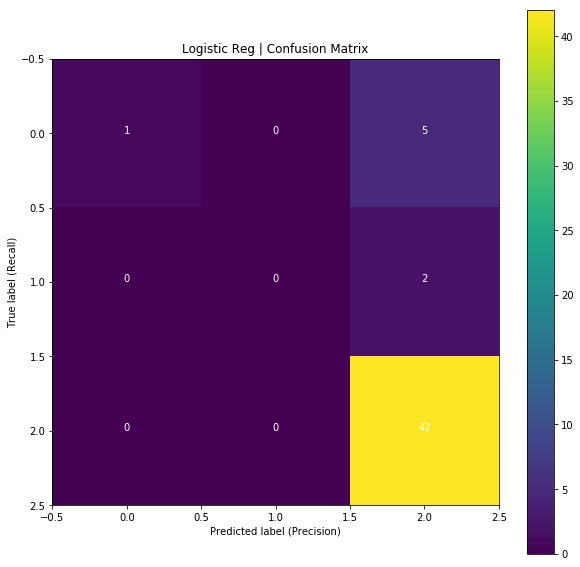

In [22]:
plt.figure(figsize = (10,10))
plt.imshow(log_cfm, interpolation='nearest')

for i, j in itertools.product(range(log_cfm.shape[0]), range(log_cfm.shape[1])):
    plt.text(j, i, log_cfm[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('Logistic Reg | Confusion Matrix')
plt.colorbar()

plt.show()

Not good enough as our model is consistently predicitng almost every thing as positive...

This is because people usually put 4/5 stars even when they are giving a negative or neutral review, so that their review has more chances of coming on top and being visible to people.

In [23]:
doc_complete = df.comment.values
doc_complete[:2]

array(['There was no bill of my order in the package.. I want my bill',
       'I got delivery within one day.overall performance like face recognition, camera quality is good. Speed of phone is ausm...i love it'],
      dtype=object)

In [37]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

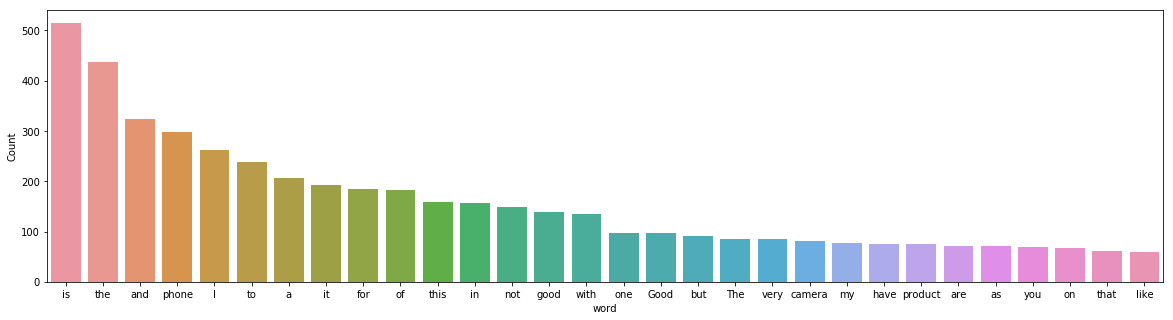

In [38]:
freq_words(df['comment'])

In [39]:
df['comment'] = df['comment'].str.replace("[^a-zA-Z#]", " ")

In [41]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [42]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['comment'] = df['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['comment']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

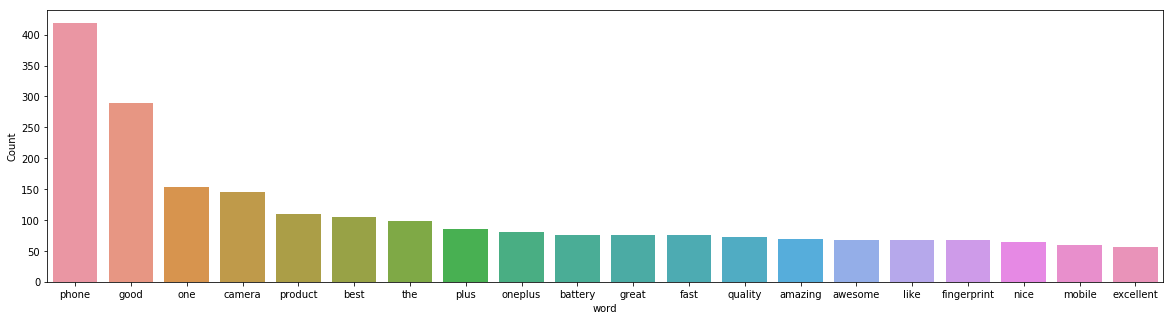

In [45]:
freq_words(reviews, 20)

To remove words like mobile, one plus etc, that refer to the product and dont explain any special quality.

In [70]:

def remove_mobile(sentence):
    rev_new = " ".join([i for i in sentence if i not in ['like','fast','best','good','amazing','awesome','great','the','one','phone','plus','oneplus','mobile','product']])
    return rev_new
reviews_wo = [remove_mobile(r.split()) for r in reviews]

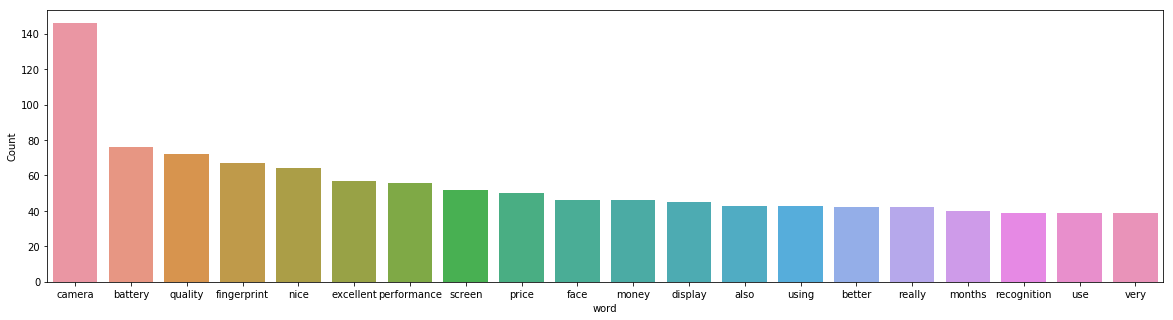

In [71]:
freq_words(reviews_wo, 20)

In [72]:
reviews_wo[:2]

['there bill order package want bill',
 'got delivery within day overall performance face recognition camera quality speed ausm love']

In [73]:
tokenized_reviews = pd.Series(reviews_wo).apply(lambda x: x.split())
print(tokenized_reviews[1])

['got', 'delivery', 'within', 'day', 'overall', 'performance', 'face', 'recognition', 'camera', 'quality', 'speed', 'ausm', 'love']


In [74]:
# Importing Gensim

# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(tokenized_reviews)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_reviews]

In [75]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics= 8, id2word = dictionary, passes=50)

In [112]:
index_topics = dict(ldamodel.print_topics(num_topics=8, num_words=10))
print(index_topics)
for i in index_topics.keys():
    index_topics[i] = index_topics[i].replace(" +" ,"")
print(index_topics)
def value_to_dict(value):
    value = value.split(" ")
    scores = dict()
    for val in value:
        val_split = val.split("*")
        scores[val_split[1][1:-1]] = float(val_split[0])
    return scores

{0: '0.016*"camera" + 0.014*"face" + 0.014*"recognition" + 0.013*"months" + 0.013*"ever" + 0.011*"performance" + 0.010*"using" + 0.010*"fingerprint" + 0.009*"working" + 0.009*"experience"', 1: '0.066*"nice" + 0.026*"camera" + 0.014*"perfect" + 0.013*"everything" + 0.012*"quality" + 0.011*"light" + 0.011*"low" + 0.010*"device" + 0.009*"very" + 0.008*"issue"', 2: '0.020*"money" + 0.020*"quality" + 0.017*"battery" + 0.017*"camera" + 0.015*"superb" + 0.012*"better" + 0.012*"worth" + 0.010*"overall" + 0.010*"screen" + 0.010*"value"', 3: '0.015*"super" + 0.012*"iphone" + 0.009*"features" + 0.009*"android" + 0.009*"all" + 0.009*"market" + 0.009*"camera" + 0.008*"use" + 0.008*"touch" + 0.007*"time"', 4: '0.067*"excellent" + 0.032*"very" + 0.018*"price" + 0.010*"dislike" + 0.009*"nothing" + 0.008*"everything" + 0.007*"buying" + 0.007*"gud" + 0.007*"for" + 0.007*"you"', 5: '0.019*"fingerprint" + 0.011*"jack" + 0.009*"missing" + 0.009*"slow" + 0.008*"sensor" + 0.008*"display" + 0.008*"headphone" 

In [114]:
value_to_dict(index_topics[0])

{'camera': 0.016,
 'face': 0.014,
 'recognition': 0.014,
 'months': 0.013,
 'ever': 0.013,
 'performance': 0.011,
 'using': 0.01,
 'fingerprint': 0.01,
 'working': 0.009,
 'experience': 0.009}

In [86]:
import nltk 
from nltk.corpus import wordnet 

 
  
def synonyms(word):
    synonyms = [] 
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonyms.append(l.name()) 
    return list(set(synonyms))

In [88]:
print(synonyms("freeze"))

['suspend', 'immobilize', 'stop_dead', 'frost', 'freeze', 'immobilise', 'block', 'freezing', 'freeze_down', 'halt', 'freeze_out']


In [89]:
buckets = ['battery','picture','money','sound','fingerprint']
buckets_words = [synonyms(x) for x in buckets]

In [90]:
buckets_words

[['electric_battery',
  'battery',
  'stamp_battery',
  'barrage',
  'shelling',
  'assault_and_battery',
  'bombardment',
  'barrage_fire'],
 ['visualise',
  'scene',
  'delineation',
  'see',
  'mental_picture',
  'depiction',
  'image',
  'video',
  'characterization',
  'motion_picture',
  'film',
  'figure',
  'visualize',
  'movie',
  'picture_show',
  'characterisation',
  'pic',
  'envision',
  'word_picture',
  'icon',
  'project',
  'motion-picture_show',
  'impression',
  'picture',
  'render',
  'moving-picture_show',
  'painting',
  'moving_picture',
  'fancy',
  'word-painting',
  'exposure',
  'photograph',
  'show',
  'ikon',
  'flick',
  'pictorial_matter',
  'depict',
  'photo'],
 ['money'],
 ['intelligent',
  'effectual',
  'reasoned',
  'auditory_sensation',
  'go',
  'speech_sound',
  'good',
  'well-grounded',
  'legal',
  'voice',
  'wakeless',
  'strait',
  'phone',
  'levelheaded',
  'fathom',
  'audio',
  'healthy',
  'vocalise',
  'profound',
  'heavy',
  'vo